In [1]:
!pip install tensorflow

In [2]:
from skimage import io
from skimage.color import rgb2gray
import matplotlib.pyplot as plt
import numpy as np
import cv2
import PIL
from scipy.stats.kde import gaussian_kde
import scipy

import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.models import Sequential
import imageio
import pathlib
from skimage.io import imread, imshow
from skimage.color import rgb2hsv, rgb2gray, rgb2yuv
from skimage import color, exposure, transform
from skimage.exposure import equalize_hist

import numpy as np
import matplotlib.pyplot as plt
from skimage import data, io, restoration, util
from skimage.color import rgb2gray
from skimage.restoration import denoise_tv_chambolle

<ipython-input-2-3a2a282a63aa>:7: DeprecationWarning: Please use `gaussian_kde` from the `scipy.stats` namespace, the `scipy.stats.kde` namespace is deprecated.
  from scipy.stats.kde import gaussian_kde


## Uploading photos

In [3]:
import pathlib

dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos.tar', origin=dataset_url, extract=True)
data_dir = pathlib.Path(data_dir).with_suffix('')

228813984/228813984 [==============================] - 2s 0us/step


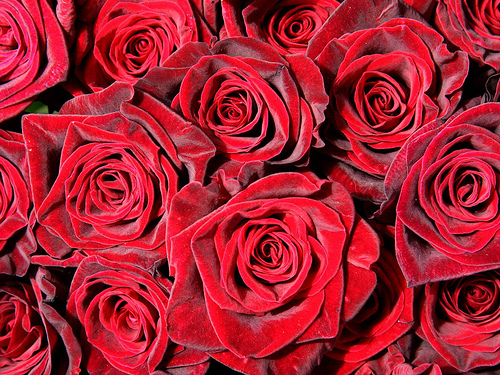

In [4]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[1]))

In [5]:
M, N = PIL.Image.open(str(roses[1])).size

<ipython-input-6-e8037a758004>:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  arr = imageio.imread(str(roses[1]))


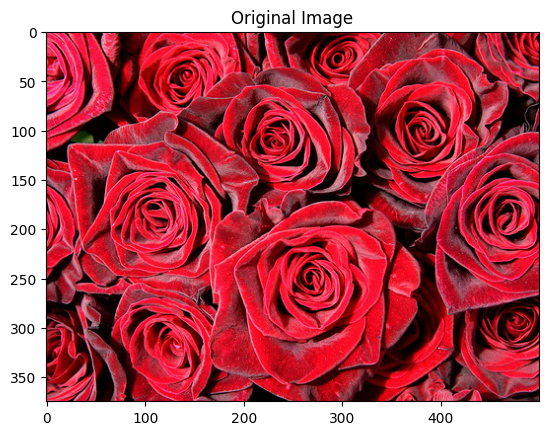

In [6]:
# Read the image as an array
arr = imageio.imread(str(roses[1]))

# Transpose the array to ensure the dimensions are (height, width, channels)
arr = np.moveaxis(arr, -1, 0)

# Transpose the array to ensure the color channels are in the first dimension
arr = np.moveaxis(arr, 0, -1)

# Display the image
plt.imshow(arr)
plt.title('Original Image')
plt.show()


## Adding noise to original images

In [7]:
# Data creation

# Create independent variable
x = np.arange(0,100,2) # Produces [0, 100) with steps of 2.

# Use a linear function to obtain the dependent variable
y = 0.3*x + 0.6 # Parameters are arbitrary.

# Noise generation

# Genearte noise with same size as that of the data.
noise = np.random.normal(0, 2, len(x)) #  μ = 0, σ = 2, size = length of x or y. Choose μ and σ wisely.

# Add the noise to the data.
y_noised = y + noise  # Since both y and noise are numpy arrays of same size, the addition is done element-wise.

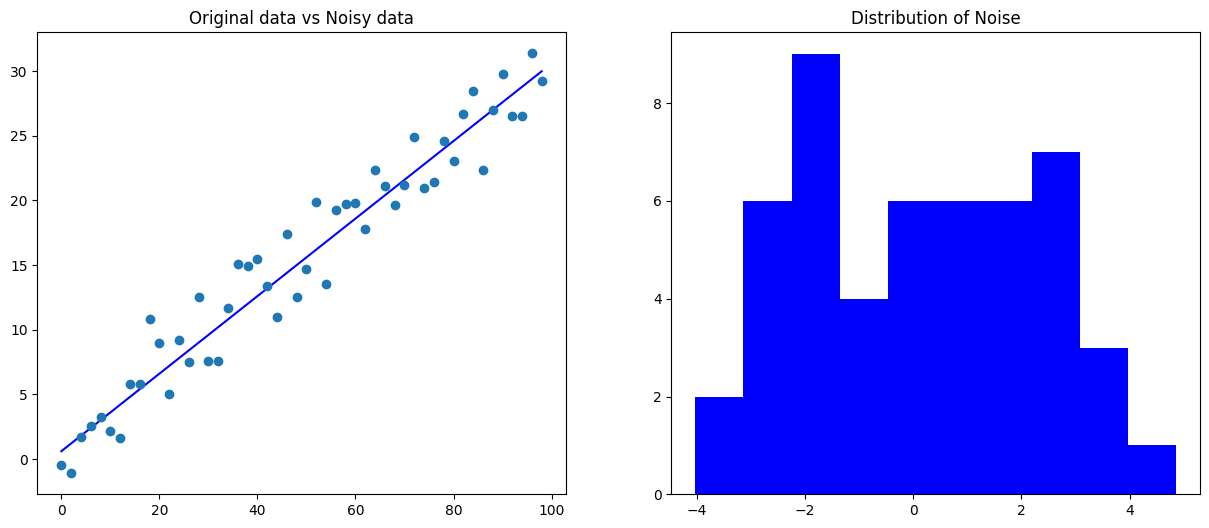

In [8]:
plt.figure(figsize=(15, 6))

# Plot the original data and the noisy data
plt.subplot(1, 2, 1)
plt.title("Original data vs Noisy data")
plt.plot(x, y, '-b')
plt.plot(x, y_noised, 'o')


# Plot the distribution of Noise
plt.subplot(1, 2, 2)
plt.hist(noise, bins=10, color='blue')
plt.title("Distribution of Noise")
plt.show()

In [9]:
# Genearte noise with same shape as that of the image
noise = np.random.normal(10, 20, arr.shape)

# Add the noise to the image
img_noised = arr + noise

# Clip the pixel values to be between 0 and 255.
img_noised = np.clip(img_noised, 0, 255).astype(np.uint8)


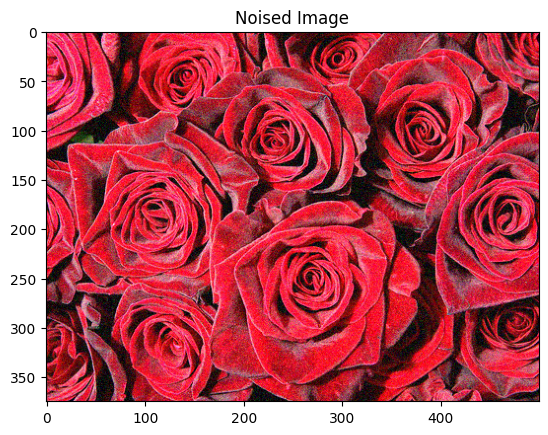

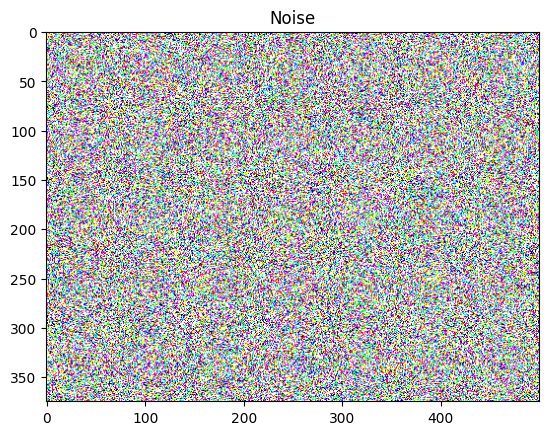

In [10]:
# Display the image
plt.imshow(img_noised)
plt.title('Noised Image')
plt.show()

# Display the noise
plt.imshow(noise)
plt.title('Noise')
plt.show()

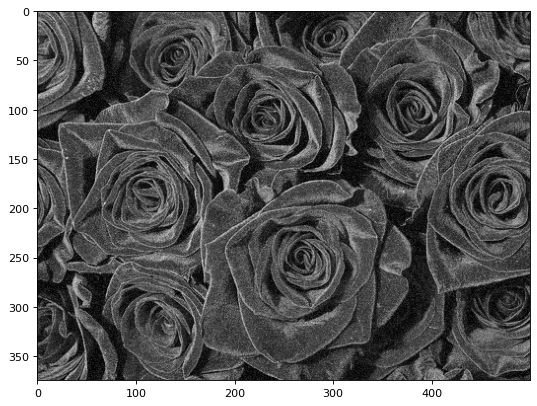

In [11]:
# Convert our image into greyscale
img_noised_grey = rgb2gray(img_noised)
plt.figure(num=None, figsize=(8, 6), dpi=80)
plt.imshow(img_noised_grey, cmap='gray');

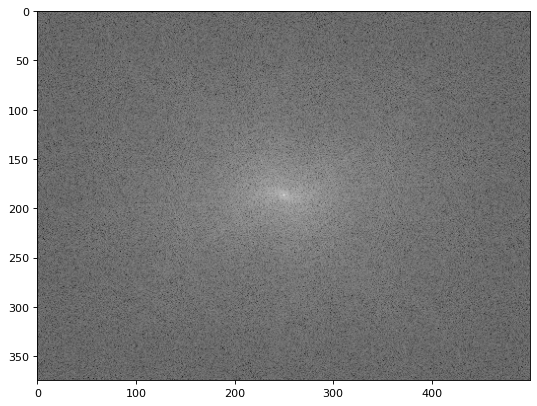

In [12]:
# Use the fft function
img_noised_grey_fourier = np.fft.fftshift(np.fft.fft2(img_noised_grey))
img_noised_grey_fourier_magnitude = np.abs(img_noised_grey_fourier)
plt.figure(num=None, figsize=(8, 6), dpi=80)
plt.imshow(np.log(img_noised_grey_fourier_magnitude), cmap='gray');

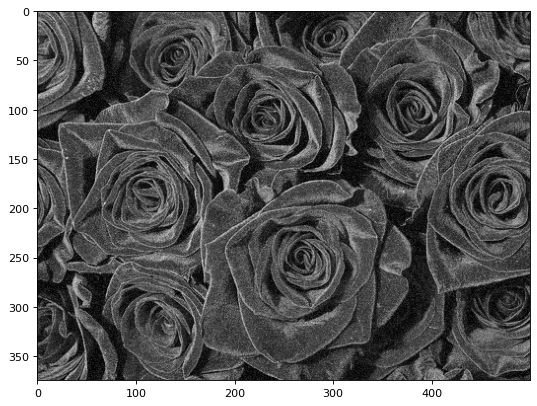

In [13]:
# Apply the inverse Fourier Transform
img_noised_grey_denoised_fourier = np.fft.ifft2(np.fft.ifftshift(img_noised_grey_fourier))
img_noised_grey_denoised = np.abs(img_noised_grey_denoised_fourier)
plt.figure(num=None, figsize=(8, 6), dpi=80)
plt.imshow(img_noised_grey_denoised, cmap='gray');

array([[0.44644357, 0.43711835, 0.43887547, ..., 0.40899932, 0.43240106,
        0.44108503],
       [0.4687211 , 0.45239159, 0.44009079, ..., 0.38939688, 0.41349665,
        0.42302454],
       [0.46448564, 0.46258416, 0.46862887, ..., 0.3640619 , 0.36597289,
        0.33749141],
       ...,
       [0.3376609 , 0.36603822, 0.39159384, ..., 0.2267716 , 0.23612168,
        0.24887439],
       [0.33127379, 0.37108727, 0.37640193, ..., 0.22316777, 0.23133283,
        0.24323097],
       [0.38630903, 0.39731734, 0.41412728, ..., 0.22204066, 0.22846475,
        0.22915766]])

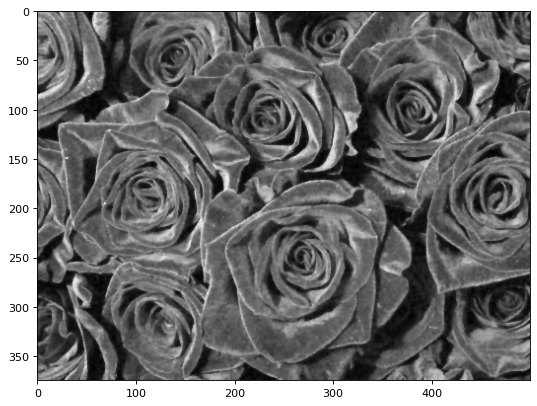

In [17]:
# Apply the Total Variation denoising algorithm
img_noised_grey_denoised_tv = denoise_tv_chambolle(img_noised_grey, weight=0.1)
plt.figure(num=None, figsize=(8, 6), dpi=80)
plt.imshow(img_noised_grey_denoised_tv, cmap='gray');



In [33]:
import numpy as np
def rgb_to_gray(rgb_image):
    gray_image = cv2.cvtColor(rgb_image, cv2.COLOR_BGR2GRAY)
    return gray_image
def psnr(img1, img2):
    mse = np.mean((img1 - img2) ** 2)

    max_pixel = 1.0

    psnr = 20 * np.log10(max_pixel / np.sqrt(mse))
    return psnr
#TV to Original
psnr_value_tv = psnr(img_noised_grey_denoised_tv,rgb_to_gray(arr))
print("PSNR TV to Original:", psnr_value_tv)
#FT to Original
psnr_value_ft = psnr(img_noised_grey_denoised,rgb_to_gray(arr))
print("PSNR FT to Original:", psnr_value_ft)

print("Difference between FT/TV to Original: ", psnr_value_ft - psnr_value_tv)
#TV to Noised
psnr_value_noised = psnr(img_noised_grey_denoised_tv,rgb_to_gray(img_noised))
print("PSNR TV to Noised:", psnr_value_noised)
#FT to Noised
psnr_value_ft_noised = psnr(img_noised_grey_denoised,rgb_to_gray(img_noised))
print("PSNR FT to Noised:", psnr_value_ft_noised)

print("Difference between FT/TV to Noised: ", psnr_value_ft_noised - psnr_value_noised )
#FT to TV
psnr_value_ft_tv = psnr(img_noised_grey_denoised, img_noised_grey_denoised_tv)
print("PSNR FT to TV:", psnr_value_ft_tv)

PSNR TV to Original: -35.99001659228004
PSNR FT to Original: -35.98779342707333
Difference between FT/TV to Original:  0.002223165206714839
PSNR TV to Noised: -37.15895414254518
PSNR FT to Noised: -37.1565165490773
Difference between FT/TV to Noised:  0.0024375934678744215
PSNR FT to TV: 23.982801567016068


In [38]:
import numpy as np
def rgb_to_gray(rgb_image):
    gray_image = cv2.cvtColor(rgb_image, cv2.COLOR_BGR2GRAY)
    return gray_image
def mse(img1, img2):
    return np.mean((img1 - img2) ** 2)

# TV to Original
mse_tv_to_original = mse(img_noised_grey_denoised_tv, rgb_to_gray(arr))
print("MSE TV to Original:", mse_tv_to_original)

# FT to Original
mse_ft_to_original = mse(img_noised_grey_denoised, rgb_to_gray(arr))
print("MSE FT to Original:", mse_ft_to_original)

# Difference between FT/TV to Original
print("Difference between FT/TV to Original: ", mse_ft_to_original - mse_tv_to_original)

# TV to Noised
mse_tv_to_noised = mse(img_noised_grey_denoised_tv, rgb_to_gray(img_noised))
print("MSE TV to Noised:", mse_tv_to_noised)

# FT to Noised
mse_ft_to_noised = mse(img_noised_grey_denoised, rgb_to_gray(img_noised))
print("MSE FT to Noised:", mse_ft_to_noised)

# Difference between FT/TV to Noised
print("Difference between FT/TV to Noised: ", mse_ft_to_noised - mse_tv_to_noised)

# FT to TV
mse_ft_to_tv = mse(img_noised_grey_denoised, img_noised_grey_denoised_tv)
print("MSE FT to TV:", mse_ft_to_tv)


MSE TV to Original: 3971.930669480829
MSE FT to Original: 3969.897947743665
Difference between FT/TV to Original:  -2.0327217371636834
MSE TV to Noised: 5198.7078743368875
MSE FT to Noised: 5195.790779783344
Difference between FT/TV to Noised:  -2.917094553543393
MSE FT to TV: 0.003996868347417026


In [48]:
import cv2
from skimage.metrics import structural_similarity as ssim

def rgb_to_gray(rgb_image):
    gray_image = cv2.cvtColor(rgb_image, cv2.COLOR_BGR2GRAY)
    return gray_image


# SSIM for TV to Original
ssim_tv_to_original = ssim(img_noised_grey_denoised_tv, rgb_to_gray(arr))
print("SSIM TV to Original:", ssim_tv_to_original)

# FT to Original
ssim_ft_to_original = ssim(img_noised_grey_denoised, rgb_to_gray(arr))
print("SSIM FT to Original:", ssim_ft_to_original)

#  TV to Noised
ssim_tv_to_noised = ssim(img_noised_grey_denoised_tv, rgb_to_gray(img_noised))
print("SSIM TV to Noised:", ssim_tv_to_noised)


# FT to Noised
ssim_ft_to_noised = ssim(img_noised_grey_denoised, rgb_to_gray(img_noised))
print("SSIM FT to Noised:", ssim_ft_to_noised)


#  FT to TV
ssim_ft_to_tv = ssim(img_noised_grey_denoised, img_noised_grey_denoised_tv)
print("SSIM FT to TV:", ssim_ft_to_tv)


/usr/local/lib/python3.10/dist-packages/skimage/_shared/utils.py:348: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  return func(*args, **kwargs)


SSIM TV to Original: 6.709310097578309e-05
SSIM FT to Original: 0.00010259350906646678
SSIM TV to Noised: 3.298297589736914e-05
SSIM FT to Noised: 7.142532044941756e-05
SSIM FT to TV: 0.7677318686666763
